In [1]:
import os.path

import platform

import pdb

import datetime as dt

import numpy as np

import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy.units as u
import astropy.time as time
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.map.maputils import all_pixel_indices_from_map,sample_at_coords
from sunpy.physics.differential_rotation import solar_rotate_coordinate

import scipy.io as io
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.stats import mode

from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')

from aiapy.calibrate import register, update_pointing, estimate_error, normalize_exposure
from aiapy.calibrate.prep import correct_degradation
import aiapy.psf

import asdf

from skimage.segmentation import expand_labels

from sklearn.cluster import KMeans

In [2]:
## Function with event information
def event_info():
    date = '2018/10/31'
    start_time = '00:00:00'
    end_time = '00:00:15' #'06:20:00'
    # bottom_left =  #[0, 0]*u.pixel 
    # top_right = [2450, 600]*u.pixel #[4095, 4095]*u.pixel 
    
    return date,start_time,end_time

## Function to download data
def get_data(date, start_time, end_time, passband, data_disk):
    ## Identify and download the data
    attrs_time = a.Time(date+' '+start_time, date+' '+end_time)
    for pbd in passband:
        wvlnth = a.Wavelength(int(pbd)*u.Angstrom, int(pbd)*u.Angstrom)
        result = Fido.search(attrs_time, a.Instrument('AIA'), wvlnth)
        files = Fido.fetch(result, path = data_disk+str(pbd).rjust(4, "0")+'/'+date, overwrite='False', progress='False')
    return
 
## Function to get the list of AIA filenames
def get_filelist(data_disk, passband):
    files = glob.glob(data_disk+str(passband).rjust(4, "0")+'/'+date+'/aia*.fits')
    files.sort()
    files_dt = [dt.datetime.strptime(file_i.split(f'{passband}a_')[1].split('z')[0], '%Y_%m_%dt%H_%M_%S_%f') for file_i in files]
    return files, files_dt

## Function to get closest file to defined file time.
def closest(list, current_time):
    ind = np.abs([time - current_time for time in list])
    return ind.argmin(0)

## Function to get AIA submap
def get_submap(time_array,index,img,f_0171):
    ind_0171 = closest(np.array(time_array[2][:]), time_array[index][img])
    aiamap = sunpy.map.Map(f_0171[ind_0171])
    bottom_left = SkyCoord(-650 * u.arcsec, -600 * u.arcsec, frame= aiamap.coordinate_frame)
    bottom_left_pix = skycoord_to_pixel(bottom_left, aiamap.wcs, origin = 0)
    w1 = 1333*u.pix
    h1 = 2000*u.pix
    submap = aiamap.submap(bottom_left_pix * u.pix, width=w1, height =h1)
    return submap

## Function to prep AIA images, deconvolve with PSF and produce submap
def prep_images(time_array,index,img,f_0094,f_0131,f_0171,f_0193,f_0211,f_0335):
    ind_0094 = closest(np.array(time_array[0][:]), time_array[index][img])
    ind_0131 = closest(np.array(time_array[1][:]), time_array[index][img])
    ind_0171 = closest(np.array(time_array[2][:]), time_array[index][img])
    ind_0193 = closest(np.array(time_array[3][:]), time_array[index][img])
    ind_0211 = closest(np.array(time_array[4][:]), time_array[index][img])
    ind_0335 = closest(np.array(time_array[5][:]), time_array[index][img])

    farray = [f_0094[ind_0094], f_0131[ind_0131], f_0171[ind_0171], f_0193[ind_0193], f_0211[ind_0211], f_0335[ind_0335]]
    maps = sunpy.map.Map(farray)
    bottom_left = SkyCoord(-650 * u.arcsec, -600 * u.arcsec, frame= maps[0].coordinate_frame)
    bottom_left_pix = skycoord_to_pixel(bottom_left, maps[0].wcs, origin = 0)
    w1 = 1333*u.pix
    h1 = 2000*u.pix
    sub = maps[0].submap(bottom_left_pix * u.pix, width=w1, height =h1)
    nx,ny = sub.data.shape
    nf=len(maps)

    print('Prepping images & deconvolving with PSF')
    map_arr = []
    error_array = np.zeros([nx, ny, nf])

    for m in range(0, len(maps)):
        psf = aiapy.psf.psf(maps[m].wavelength)
        aia_map_deconvolved = aiapy.psf.deconvolve(maps[m], psf=psf)
        aia_map_updated_pointing = update_pointing(aia_map_deconvolved)
        aia_map_registered = register(aia_map_updated_pointing)
        aia_map_corrected = correct_degradation(aia_map_registered)
        aia_map_norm = normalize_exposure(aia_map_corrected)
        bottom_left = SkyCoord(-650 * u.arcsec, -600 * u.arcsec, frame= maps[m].coordinate_frame)
        bottom_left_pix = skycoord_to_pixel(bottom_left, maps[m].wcs, origin = 0)
        submap = aia_map_norm.submap(bottom_left_pix * u.pix, width=w1, height =h1)
        map_arr.append(submap)
        num_pix=submap.data.size
        error_array[:,:,m] = estimate_error(submap.data*(u.ct/u.pix),submap.wavelength,num_pix)

    map_array=sunpy.map.Map(map_arr[0],map_arr[1],map_arr[2],map_arr[3],
                            map_arr[4],map_arr[5],sequence=True,sortby=None) 
    print('Images prepped & region of interest selected')

    return map_array, error_array
    
## Function to calculate DEM
def calculate_dem(map_array, err_array):
    nx,ny = map_array[0].data.shape
    nf=len(map_array)
    image_array = np.zeros((nx,ny,nf))
    for img in range(0,nf):
        image_array[:,:,img] = map_array[img].data

    trin=io.readsav('/Users/nawinngampoopun/Desktop/Script/demreg/python/aia_tresp_en.dat')
    tresp_logt=np.array(trin['logt'])
    nt=len(tresp_logt)
    nf=len(trin['tr'][:])
    trmatrix=np.zeros((nt,nf))
    for i in range(0,nf):
        trmatrix[:,i]=trin['tr'][i]    
    
    t_space=0.1
    #probably should change to logT = 5.3-6.5 (Heinemann2021)
    t_min=5.6
    t_max=7.4
    logtemps=np.linspace(t_min,t_max,num=int((t_max-t_min)/t_space)+1)
    temps=10**logtemps
    mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) for i in np.arange(0,len(temps)-1)])
    dem,edem,elogt,chisq,dn_reg=dn2dem_pos(image_array,err_array,trmatrix,tresp_logt,temps,max_iter=15)
    dem = dem.clip(min=0)
    return dem,edem,elogt,chisq,dn_reg,mlogt,logtemps

## Function to plot the DEM curve for the centre pixel
def plot_dem(dem,edem,mlogt,elogt,img_tit):
    sz = dem.shape
    pixel_loc = [int(sz[1]/2)-100, int(sz[0]/2)-100]
    fig = plt.figure(figsize=(8, 4.5))
    dem_pix = dem[pixel_loc[0],pixel_loc[1],]
    dem_pix_err = edem[pixel_loc[0],pixel_loc[1],]
    elogt_pix = elogt[pixel_loc[0],pixel_loc[1],]
    plt.errorbar(mlogt,dem_pix,xerr=elogt_pix,yerr=dem_pix_err, fmt='or',ecolor='lightcoral',elinewidth=3,capsize=0,label='Def Self LWght')
    plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
    plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
    plt.ylim([1e18,4e20])
    plt.xlim([5.2,6.6])
    plt.rcParams.update({'font.size': 16})
    plt.yscale('log')
    plt.legend()
    plt.savefig(img_tit,bbox_inches='tight')
    plt.close(fig)
    
    return

## Function to plot the DEM images
def plot_dem_images(submap,dem,logtemps,img_arr_tit, CHB, CHB_in, CHB_out):
    sz = dem.shape
    pixel_loc = [int(sz[1]/2)-100, int(sz[0]/2)-100]
    nt=len(dem[0,0,:])
    nt_new=int(nt/2)
    nc, nr = 3, 2
    plt.rcParams.update({'font.size': 12,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(12,6),sharex=True,sharey=True)
    fig.suptitle('Image time = '+time.Time.strftime(submap.date, "%Y-%m-%dT%H:%M:%S"))
    fig.supxlabel('Pixels')
    fig.supylabel('Pixels')
    cmap = plt.cm.get_cmap('cubehelix_r')
    
    for i, axi in enumerate(axes.flat):
        new_dem= (dem[:,:,i*4]+dem[:,:,i*4+3])/2.
        im = axi.imshow(new_dem,vmin=1e19,vmax=1e21,origin='lower',cmap=cmap, aspect='equal')
        axi.plot(pixel_loc[0],pixel_loc[1],'x',markersize='10')
        axi.contour(CHB, colors = 'black',linewidths=0.5)
        axi.contour(CHB_in,colors = 'red',linewidths =0.5)
        axi.contour(CHB_out, colors = 'blue',linewidths =0.5)
        axi.set_title('{0:.2f} - {1:.2f}'.format(logtemps[i*4],logtemps[i*4+3+1]))

    plt.tight_layout()
    plt.colorbar(im, ax=axes.ravel().tolist(),label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',fraction=0.03, pad=0.02)
    plt.savefig(img_arr_tit, bbox_inches='tight')
    plt.close(fig)
    return

In [3]:
#Calculate and plot EM maps for 9 temperature bins
def plot_em_images_calc(submap,dem,logtemps, img_EM_tit, CHB, CHB_in, CHB_out):
    EM_total = np.sum(dem,axis=2)
    EM_bin = np.zeros((dem.shape[0], dem.shape[1], dem.shape[2]//4))
    for i in range (EM_bin.shape[2]):
        EM_bin[:,:,i] = dem[:,:,i*4] + dem[:,:,i*4+3]
        
    nc, nr = 3, 2
    plt.rcParams.update({'font.size': 12,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(12,6),sharex=True,sharey=True)
    fig.suptitle('Image time = '+time.Time.strftime(submap.date, "%Y-%m-%dT%H:%M:%S"))
    fig.supxlabel('Pixels')
    fig.supylabel('Pixels')
    cmap = plt.cm.get_cmap('cubehelix_r')
        
    for i, axi in enumerate(axes.flat):
        im = axi.imshow(EM_bin[:,:,i],vmin=1e19,vmax=1e21,origin='lower',cmap=cmap, aspect='equal')
        axi.contour(CHB, colors = 'black',linewidths=0.5)
        axi.contour(CHB_in,colors = 'red',linewidths =0.5)
        axi.contour(CHB_out, colors = 'blue',linewidths =0.5)
        axi.set_title('{0:.2f} - {1:.2f}'.format(logtemps[i*4],logtemps[i*4+3+1]))
    
    plt.tight_layout()
    plt.colorbar(im, ax=axes.ravel().tolist(),label='$\mathrm{EM\;[cm^{-5}]}$',fraction=0.03, pad=0.02)
    plt.savefig(img_EM_tit, bbox_inches='tight')
    plt.close(fig)
    
    return EM_total

In [4]:
#plot EM weighted temperature and density map based by Saqri(2020)
def plot_temp_images(submap,dem, EM_total,logtemps, img_temp_tit, CHB, CHB_in, CHB_out):
    temps = 10**(logtemps)
    upfrac = np.zeros((EM_total.shape))
    for j in range (dem.shape[2]):
        upfrac_plus = dem[:,:,j]*temps[j]
        upfrac = upfrac+upfrac_plus

    T_weighted = upfrac/EM_total
    T_min = np.nanmin(T_weighted)
    T_weighted_plot = np.nan_to_num(T_weighted,nan=0)
    
    plt.rcParams.update({'font.size': 12,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})
    cmap = plt.cm.get_cmap('afmhot')
    cmap.set_bad(color='green')
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection=submap)
    ax.set_title('Image time = '+time.Time.strftime(submap.date, "%Y-%m-%dT%H:%M:%S"))
    ax.set_xlabel('arcsec')
    ax.set_ylabel('arcsec')
    im = ax.imshow(T_weighted_plot,vmin = T_min, vmax = 3e6,origin='lower',cmap=cmap,aspect='equal')
    ax.contour(CHB, colors = 'black',linewidths=0.5)
    ax.contour(CHB_in,colors = 'red',linewidths =0.5)
    ax.contour(CHB_out, colors = 'blue',linewidths =0.5)
    plt.tight_layout()
    plt.colorbar(im,label='$\mathrm{T\;[K]}$',fraction=0.03, pad=0.02)
    plt.savefig(img_temp_tit, bbox_inches='tight')
    plt.close(fig)
    return T_weighted_plot

def plot_dens_images(submap, EM_total, img_dens_tit, CHB, CHB_in, CHB_out):
    #Scale Height = 42 Mm (Saqri 2020)
    h_saq = 42*(10**8) #cm
    #Calc mean density
    density_mean_saq = np.sqrt(EM_total/h_saq)
    dens_min = np.min(density_mean_saq[np.nonzero(density_mean_saq)])
    dens_max = np.max(density_mean_saq)
    
    plt.rcParams.update({'font.size': 12,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})
    cmap = plt.cm.get_cmap('bone')
    cmap.set_bad(color='green')
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection=submap)
    ax.set_title('Image time = '+time.Time.strftime(submap.date, "%Y-%m-%dT%H:%M:%S"))
    ax.set_xlabel('arcsec')
    ax.set_ylabel('arcsec')
    im = ax.imshow(density_mean_saq,vmin = dens_min, vmax = 1e6,origin='lower',cmap=cmap,aspect='equal')
    ax.contour(CHB, colors = 'black',linewidths=0.5)
    ax.contour(CHB_in,colors = 'red',linewidths =0.5)
    ax.contour(CHB_out, colors = 'blue',linewidths =0.5)
    plt.tight_layout()
    plt.colorbar(im,label=r'$\bar{n} \mathrm{[cm^{-3}]}$',fraction=0.03, pad=0.02)
    plt.savefig(img_dens_tit, bbox_inches='tight')
    plt.close(fig)
    return density_mean_saq

In [5]:
#Define Essential Component Function

#Define Coronal Hole Boundary
def define_CHB (aiamap, subaiamap, subaiamap_mask): 
    #Mask the spotted that brighter than 50% of median intensity of solar disk
    #Base on CATCH(Heinemann2019): 46.2 \pm 5.5 of Median
    mask = subaiamap.data > 0.35 * np.median(aiamap.data)
    subaiamap_mask.mask = mask
    #Gaussian Filtering to Connect Smaller Region
    data1 = ndimage.gaussian_filter(subaiamap.data * ~mask, 5) #gaussian filtering
    #labels the area define in CH
    subaiamap_new = sunpy.map.Map(data1, subaiamap.meta)
    labels, n = ndimage.label(subaiamap_new.data)
    #Select only biggest CH
    vallabel = mode(labels[np.nonzero(labels)])
    labels_true = np.where(labels == vallabel[0], labels, 0)
    #Fill Bright spots in CH (We neglected them)
    labels_true = ndimage.binary_fill_holes(labels_true).astype(int)
    return subaiamap_new, labels_true

#expand CHB boundary
#from skimage.segmentation import expand_labels

#shrink CHB boundary
def erode_labels(segmentation, erosion_iterations):
    # create empty list where the eroded masks can be saved to
    list_of_eroded_masks = list()

    # binarize each of the labels separately and save the output to the created list of numpy arrays
    def erode_mask(segmentation_labels, label_id, erosion_iterations):
        
        only_current_label_id = np.where(segmentation_labels == label_id, 1, 0)
        eroded = ndimage.binary_erosion(only_current_label_id, iterations = erosion_iterations)
        relabeled_eroded = np.where(eroded == 1, i, 0)
        return(relabeled_eroded)

    for i in range(len(np.unique(segmentation))):
        list_of_eroded_masks.append(erode_mask(segmentation, i, erosion_iterations))

    # convert list of numpy arrays to stacked numpy array
    final_array = np.stack(list_of_eroded_masks)

    # max_IP to reduce the stack of arrays, each containing one labelled region, to a single 2D np array. 
    final_array_labelled = np.max(final_array, axis = 0)
    return(final_array_labelled)

#Define CHB annulus
def define_CHB_annulus(labels, pixel):
    labels_out = expand_labels(labels,pixel)
    labels_in = erode_labels(labels, 40)
    return labels_out, labels_in

#Mask Other Area and Select only CHB Annulus
def mask_annulus(submap, labels1, labels2):
    #pixel_coord = all_coordinates_from_map(submap)
    annulus_label = labels1 - labels2
    submap_annulus_data = np.where(annulus_label > 0, submap.data, np.NaN)
    #CH_annulus_coord = pixel_coord[annulus_label > 0]
    CH_annulus_pixel = np.nonzero(annulus_label)
    CH_annulus_pixel_array = np.column_stack((CH_annulus_pixel[1],CH_annulus_pixel[0]))
    annulusmap = sunpy.map.Map(submap_annulus_data, submap.meta)
    return annulusmap, CH_annulus_pixel_array

#Kmean clustering for ref image
def kmeanscluster (pixelarray, num_segment):
    rng = np.random.RandomState(0)
    kmeans = KMeans(n_clusters=num_segment, tol = 1e-5, random_state = rng).fit(pixelarray)
    centroids = kmeans.cluster_centers_
    labels_section = kmeans.labels_
    labelsnum = np.arange(0,num_segment)
    centroids = np.column_stack((centroids[:,0],centroids[:,1],labelsnum))
    print(kmeans.n_iter_)
    return centroids, labels_section

#Kmeans clustering with initial centroid
def kmeanscluster_initcen(pixelarray, num_segment, centroidref):
    rng = np.random.RandomState(0)
    kmeans = KMeans(n_clusters=num_segment, tol = 1e-5, random_state = rng, init=centroidref[:,:2]).fit(pixelarray)
    centroids = kmeans.cluster_centers_
    labels_section = kmeans.labels_
    labelsnum = np.arange(0,num_segment)
    centroids = np.column_stack((centroids[:,0],centroids[:,1],labelsnum))
    print(kmeans.n_iter_)
    return centroids, labels_section

#Find index of elements that closest to contour line
def closest_node_index(node, nodes):
    return cdist([node], nodes).argmin()

#Sort Centroid for first image (from min, from max, from reference point)
def sort_centroid_frommax(centroid_array_input):
    centroid_array = np.copy(centroid_array_input)
    centroid_sort = np.zeros(np.shape(centroid_array))
    ref = centroid_array[np.nonzero(centroid_array[:,1] == np.max(centroid_array[:,1]))]
    centroid_sort[0] = ref
    for j in range (len(centroid_array)-1):
        cut_x = np.nonzero(centroid_array[:,0] == ref[0,0])
        cut_y = np.nonzero(centroid_array[:,1] == ref[0,1])
        #print(cut_x, cut_y)
        centroid_array = np.delete(centroid_array,cut_x,0)
        #print(centroid_array.shape)
        ref_temp = centroid_array[closest_node_index((ref[0,:2]),centroid_array[:,0:2])]
        ref = ref_temp.reshape(1,3)
        centroid_sort[j+1] = ref       
    return centroid_sort

def sort_centroid_frommin(centroid_array_input):
    centroid_array = np.copy(centroid_array_input)
    centroid_sort = np.zeros(np.shape(centroid_array))
    ref = centroid_array[np.nonzero(centroid_array[:,1] == np.min(centroid_array[:,1]))]
    centroid_sort[0] = ref
    for j in range (len(centroid_array)-1):
        cut_x = np.nonzero(centroid_array[:,0] == ref[0,0])
        cut_y = np.nonzero(centroid_array[:,1] == ref[0,1])
        #print(cut_x, cut_y)
        centroid_array = np.delete(centroid_array,cut_x,0)
        #print(centroid_array.shape)
        ref_temp = centroid_array[closest_node_index((ref[0,:2]),centroid_array[:,0:2])]
        ref = ref_temp.reshape(1,3)
        centroid_sort[j+1] = ref      
    return centroid_sort

def sort_centroid_fromref(centroid_array_input, refinput):
    centroid_array = np.copy(centroid_array_input)
    centroid_sort = np.zeros(np.shape(centroid_array))
    ref = refinput.reshape(1,3)
    centroid_sort[0] = ref
    for j in range (len(centroid_array)-1):
        cut_x = np.nonzero(centroid_array[:,0] == ref[0,0])
        cut_y = np.nonzero(centroid_array[:,1] == ref[0,1])
        #print(cut_x, cut_y)
        centroid_array = np.delete(centroid_array,cut_x,0)
        #print(centroid_array.shape)
        ref_temp = centroid_array[closest_node_index((ref[0,:2]),centroid_array[:,0:2])]
        ref = ref_temp.reshape(1,3)
        centroid_sort[j+1] = ref      
    return centroid_sort

#Sort Cluster label with centroid
def sortlabel(labels_section, sort_centroids, num_segment):
    labels_section_sort = np.copy(labels_section)
    for k in range (num_segment):
        labels_section_sort[np.nonzero(labels_section == k)] = np.nonzero(sort_centroids[:,2] == k)
    return labels_section_sort

#Kmeans Clustering overall process for reference image
def segment_annulus_ultimate(CH_annulus_pixel_array,num_totarea):
    num_area = 2
    centroids, labels_section = kmeanscluster(CH_annulus_pixel_array, num_area)
    centroids_sorttest = sort_centroid_frommin(centroids)
    labels_section_sorted = sortlabel(labels_section,centroids_sorttest,num_area)
    CH_annulus_pixel_array_sub1x = CH_annulus_pixel_array[:,0][labels_section_sorted == 0]
    CH_annulus_pixel_array_sub1y = CH_annulus_pixel_array[:,1][labels_section_sorted == 0]
    CH_annulus_pixel_array_sub1 = np.column_stack((CH_annulus_pixel_array_sub1x,CH_annulus_pixel_array_sub1y))
    CH_annulus_pixel_array_sub2x = CH_annulus_pixel_array[:,0][labels_section_sorted == 1]
    CH_annulus_pixel_array_sub2y = CH_annulus_pixel_array[:,1][labels_section_sorted == 1]
    CH_annulus_pixel_array_sub2 = np.column_stack((CH_annulus_pixel_array_sub2x,CH_annulus_pixel_array_sub2y))
    num_subarea = num_totarea//2
    centroids_sub1, labels_section_sub1 = kmeanscluster(CH_annulus_pixel_array_sub1, num_subarea)
    centroids_sub1_sorttest = sort_centroid_frommax(centroids_sub1)
    labels_section_sub1_sorted = sortlabel(labels_section_sub1,centroids_sub1_sorttest,num_subarea)
    centroids_sub2, labels_section_sub2 = kmeanscluster(CH_annulus_pixel_array_sub2, num_subarea)
    ref2 = centroids_sub2[closest_node_index(centroids_sub1_sorttest[-1],centroids_sub2)]
    centroids_sub2_sorttest = sort_centroid_fromref(centroids_sub2, ref2)
    #centroids_sub2_sorttest = sort_centroid_frommin(centroids_sub2)
    labels_section_sub2_sorted = sortlabel(labels_section_sub2,centroids_sub2_sorttest,num_subarea)
    labels_section_sub2_sorted = labels_section_sub2_sorted + np.max(labels_section_sub1_sorted)
    centroids_sortedtrue = np.concatenate((centroids_sub1_sorttest, centroids_sub2_sorttest))
    labels_section_sortedtrue = np.concatenate((labels_section_sub1_sorted,labels_section_sub2_sorted))
    CH_annulus_pixel_array_sorted = np.concatenate((CH_annulus_pixel_array_sub1,CH_annulus_pixel_array_sub2))
    
    return CH_annulus_pixel_array_sorted, centroids_sortedtrue, labels_section_sortedtrue 

In [6]:
#Function for running all process
#Ref image
def CHB_process_firstimage(aiamap):
    #Load AIAMAP and def mask
    aia1 = sunpy.map.Map(aiamap)
    aia1_mask = sunpy.map.Map(aiamap)
    #Define Submap for First Image, will be reference to every image
    bottom_left = SkyCoord(-650 * u.arcsec, -600 * u.arcsec, frame= aia1.coordinate_frame)
    bottom_left_pix = skycoord_to_pixel(bottom_left, aia1.wcs, origin=0)
    w1 = 1333*u.pix
    h1 = 2000*u.pix
    #subaia1 = aia1.submap(bottom_left, width = w1, height = h1)
    subaia1 = aia1.submap(bottom_left_pix * u.pix, width = w1, height = h1)
    #subaia1_mask = aia1_mask.submap(bottom_left, width = w1, height = h1)
    subaia1_mask = aia1_mask.submap(bottom_left_pix * u.pix, width = w1, height = h1)
    #Define CHB and Annulus
    subaia1_new, labels1 = define_CHB(aia1, subaia1, subaia1_mask) #CHB
    labels1_out, labels1_in = define_CHB_annulus(labels1, 40) #Annulus
    CH1_annulus, CH1_annulus_pixel = mask_annulus(subaia1, labels1_out, labels1_in) #CHB map and pixel
    CH1_annulus_inner, CH1_annulus_inner_pixel = mask_annulus(subaia1, labels1, labels1_in) #CHB inner map and pixel
    CH1_annulus_outer, CH1_annulus_outer_pixel = mask_annulus(subaia1, labels1_out, labels1)#CHB outer map and pixel
    #Segmenting Annulus Subarea and Sorted
    CH_outer_sort, centroid2, labels2 = segment_annulus_ultimate(CH1_annulus_outer_pixel, 60)
    CH_inner_sort, centroid3, labels3 = segment_annulus_ultimate(CH1_annulus_inner_pixel, 60)
    
    return bottom_left, centroid2, centroid3, labels1, labels1_out, labels1_in, labels2, labels3, CH1_annulus_outer, CH1_annulus_inner, CH_outer_sort, CH_inner_sort

#Otherimage
def CHB_process_otherimage(aiamap,bottom_left_ref, centroidouter_ref, centroidinner_ref):
    aia1 = sunpy.map.Map(aiamap)
    aia1_mask = sunpy.map.Map(aiamap)
    #Shift Bottomleft Coor to new observer
    bottom_left = solar_rotate_coordinate(bottom_left_ref, observer = aia1.observer_coordinate)
    #bottom_left_pix = skycoord_to_pixel(bottom_left, aia1.wcs)
    w1 = 800*u.arcsec
    h1 = 1200*u.arcsec
    subaia1 = aia1.submap(bottom_left, width = w1, height = h1)
    subaia1_mask = aia1_mask.submap(bottom_left, width = w1, height = h1)
    #Define CHB and Annulus
    subaia1_new, labels1 = define_CHB(aia1, subaia1, subaia1_mask) #CHB
    labels1_out, labels1_in = define_CHB_annulus(labels1, 40) #Annulus
    CH1_annulus, CH1_annulus_pixel = mask_annulus(subaia1, labels1_out, labels1_in) #CHB map and pixel
    CH1_annulus_inner, CH1_annulus_inner_pixel = mask_annulus(subaia1, labels1, labels1_in) #CHB inner map and pixel
    CH1_annulus_outer, CH1_annulus_outer_pixel = mask_annulus(subaia1, labels1_out, labels1)#CHB outer map and pixel
    #Segmenting Annulus Subarea and Sorted
    centroid2, labels2 = kmeanscluster_initcen(CH1_annulus_outer_pixel, 60, centroidouter_ref)
    centroid3, labels3 = kmeanscluster_initcen(CH1_annulus_inner_pixel, 60, centroidinner_ref)
    
    
    return bottom_left, centroid2, centroid3, labels1, labels1_out, labels1_in, labels2, labels3, CH1_annulus_outer, CH1_annulus_inner, CH1_annulus_outer_pixel, CH1_annulus_inner_pixel

In [7]:
def pixeltransform_AIA(xpixelaia, ypixelaia, subaiamapwcs, subaiamap_new):
    aia_subarea_sky = pixel_to_skycoord(xpixelaia,ypixelaia,subaiamapwcs,origin=0)
    aianew_subarea_sky = solar_rotate_coordinate(aia_subarea_sky, observer=subaiamap_new.observer_coordinate)
    aianew_subarea_pix= skycoord_to_pixel(aianew_subarea_sky, wcs=subaiamap_new.wcs,origin=0)
    aianew_subarea_pix_x = (np.rint(aianew_subarea_pix[0])).astype(int)
    aianew_subarea_pix_y = (np.rint(aianew_subarea_pix[1])).astype(int)
    labelsmock_subarea_array = np.zeros(subaiamap_new.data.shape, dtype=int)
    labelsmock_subarea_array[aianew_subarea_pix_y,aianew_subarea_pix_x] = 1
    # #IMPORTANT!!!!!! DoubleBInaryCLosing
    # #Rowwise
    # for i in range (len(labelsmock_subarea_array)):
    #     labelsmock_subarea_array[i] = ndimage.binary_closing(labelsmock_subarea_array[i]).astype(int)
    # #Overall
    labelsmock_subarea_array = ndimage.binary_closing(labelsmock_subarea_array).astype(int)
    labelsmock_subarea, n2 = ndimage.label(labelsmock_subarea_array)
    if n2 != 1: 
        print("ERROR with binary closing with n ={} at {}".format(n2, subaiamap_new.date))
    
    return labelsmock_subarea

def Selectprop_DEM(proparray, labels):
    #submap_data = subaiamap.data   
    prop_selectarea_data = proparray[labels != 0]
    meanprop_subarea = np.mean(prop_selectarea_data)

    return meanprop_subarea


In [8]:
date,start_time,end_time = event_info()

In [9]:
data_disk = '/Users/nawinngampoopun/Desktop/SampleDEM/data/'
output_dir = '/Users/nawinngampoopun/Desktop/SampleDEM/results/'

os.makedirs(data_disk, exist_ok='True')
os.makedirs(output_dir, exist_ok='True')
passband = [94, 131, 171, 193, 211, 335]

In [10]:
f_0094, time_0094 = get_filelist(data_disk, 94)
f_0131, time_0131 = get_filelist(data_disk, 131)
f_0171, time_0171 = get_filelist(data_disk, 171)
f_0193, time_0193 = get_filelist(data_disk, 193)
f_0211, time_0211 = get_filelist(data_disk, 211)
f_0335, time_0335 = get_filelist(data_disk, 335)

In [11]:
flength = [len(f_0094), len(f_0131), len(f_0171), len(f_0193), len(f_0211), len(f_0335)]
flist = [f_0094, f_0131, f_0171, f_0193, f_0211, f_0335]
time_array = [time_0094, time_0131, time_0171, time_0193, time_0211, time_0335]
index = np.argmin(flength)

In [11]:
aia193 = sunpy.map.Map('/Users/nawinngampoopun/Desktop/Testdata/aia193_L16_0.fits')
aia193_corr = correct_degradation(aia193)

In [12]:
bottom_left, centroid_outer, centroid_inner, CHB, CHB_out, CHB_in, labels_outer, labels_inner, submap_outer_run, submap_inner_run, CHouterpixel, CHinnerpixel = CHB_process_firstimage(aia193_corr)

4
85


KeyboardInterrupt: 

In [14]:
# Begin image processing
for img in range(0, len(flist[index])):

    print('Processing image, time = '+dt.datetime.strftime(time_array[index][img], "%Y-%m-%dT%H:%M:%S"))

    # Get and process images.
    err_arr_tit = output_dir+'error_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.asdf'
    map_arr_tit = output_dir+'prepped_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'_{index:03}.fits'
    files = os.path.exists(err_arr_tit)
    if files == False:
        map_array, err_array = prep_images(time_array,index,img,f_0094,f_0131,f_0171,
                                               f_0193,f_0211,f_0335)
        map_array.save(map_arr_tit,overwrite='True')
        tree = {'err_array':err_array}
        with asdf.AsdfFile(tree) as asdf_file:
                asdf_file.write_to(err_arr_tit)
    else:
        print('Loading previously prepped images')
        arrs = asdf.open(err_arr_tit)
        err_array = arrs['err_array']
        ffin=sorted(glob.glob(output_dir+'prepped_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'*.fits'))
        map_array=sunpy.map.Map(ffin)
    # Calculate DEMs
    dem_arr_tit = output_dir+'dem_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.asdf'
    files = os.path.exists(dem_arr_tit)
    if files == False:
        print('Calculating DEM')
        dem,edem,elogt,chisq,dn_reg,mlogt,logtemps = calculate_dem(map_array,err_array)
        tree = {'dem':dem, 'edem':edem, 'mlogt':mlogt, 'elogt':elogt, 'chisq':chisq, 'logtemps':logtemps}
        with asdf.AsdfFile(tree) as asdf_file:  
            asdf_file.write_to(dem_arr_tit)
    else:
        print('Loading previously calculated DEM')
        arrs = asdf.open(dem_arr_tit)  
        dem = arrs['dem']
        edem = arrs['edem']
        mlogt = arrs['mlogt']
        elogt = arrs['elogt']
        chisq = arrs['chisq']
        logtemps = arrs['logtemps']
        CHB_all = np.load('/Users/nawinngampoopun/Desktop/SampleDEM/results/CHB_all.npz')
        CHB = CHB_all['CHB']
        CHB_in = CHB_all['CHB_in']
        CHB_out = CHB_all['CHB_out']
        
    # Plot results for center pix
    img_tit = output_dir+'Centre_pixel_DEM_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    plot_pix = plot_dem(dem,edem,mlogt,elogt,img_tit)
    
    # Get a submap to have the scales and image properties.
    submap = get_submap(time_array,index,img,f_0171)
    
    #Plot map of plasma prop
    img_arr_tit = output_dir+'DEM_images_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    plot_demmap = plot_dem_images(submap,dem,logtemps,img_arr_tit,CHB, CHB_in, CHB_out)
    img_EM_tit = output_dir+'EM_images_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    EM_total = plot_em_images_calc(submap,dem,logtemps,img_EM_tit,CHB, CHB_in, CHB_out)
    img_temp_tit = output_dir+'Temp_map_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    Tempmap = plot_temp_images(submap,dem,EM_total,logtemps,img_temp_tit,CHB, CHB_in, CHB_out)
    img_dens_tit = output_dir+'Dens_map_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    Densmap = plot_dens_images(submap, EM_total, img_dens_tit,CHB, CHB_in, CHB_out)
    
     #Get values from subregion
    landf_pix = np.load('/Users/nawinngampoopun/Desktop/SampleDEM/results/leadandfollow_pix.npz')
    pixel_lead_outer = landf_pix['pixel_lead_outer']
    pixel_lead_inner = landf_pix['pixel_lead_inner']
    pixel_fol_outer = landf_pix['pixel_fol_outer']
    pixel_fol_inner = landf_pix['pixel_fol_inner']
    labelsaia_lead_outer = pixeltransform_AIA(pixel_lead_outer[0], pixel_lead_outer[1], submap.wcs,submap)
    labelsaia_lead_inner = pixeltransform_AIA(pixel_lead_inner[0], pixel_lead_inner[1], submap.wcs,submap)
    labelsaia_fol_outer = pixeltransform_AIA(pixel_fol_outer[0], pixel_fol_outer[1], submap.wcs,submap)
    labelsaia_fol_inner = pixeltransform_AIA(pixel_fol_inner[0], pixel_fol_inner[1], submap.wcs,submap)
    meanEM_lead_outer = Selectprop_DEM(EM_total, labelsaia_lead_outer)
    meanEM_lead_inner = Selectprop_DEM(EM_total, labelsaia_lead_inner)
    meanEM_fol_outer = Selectprop_DEM(EM_total, labelsaia_fol_outer)
    meanEM_fol_inner = Selectprop_DEM(EM_total, labelsaia_fol_inner)
    meanT_lead_outer = Selectprop_DEM(Tempmap, labelsaia_lead_outer)
    meanT_lead_inner = Selectprop_DEM(Tempmap, labelsaia_lead_inner)
    meanT_fol_outer = Selectprop_DEM(Tempmap, labelsaia_fol_outer)
    meanT_fol_inner = Selectprop_DEM(Tempmap, labelsaia_fol_inner)
    meanDens_lead_outer = Selectprop_DEM(Densmap, labelsaia_lead_outer)
    meanDens_lead_inner = Selectprop_DEM(Densmap, labelsaia_lead_inner)
    meanDens_fol_outer = Selectprop_DEM(Densmap, labelsaia_fol_outer)
    meanDens_fol_inner = Selectprop_DEM(Densmap, labelsaia_fol_inner)
   
    


Processing image, time = 2018-10-31T00:00:11
Loading previously prepped images
Loading previously calculated DEM


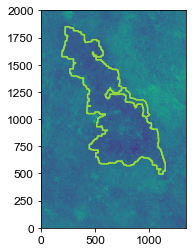

In [16]:
plt.imshow(Tempmap, origin='lower')
plt.contour(CHB)
plt.contour(labelsaia_lead_outer)

701607.8876840469

In [61]:
CHB_in

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
submap.data.shape

(2001, 1334)

In [65]:
logtemps

array([5.3 , 5.35, 5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 ,
       5.85, 5.9 , 5.95, 6.  , 6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35,
       6.4 , 6.45, 6.5 ])

In [66]:
temps = 10**(logtemps)

In [67]:
temps

array([ 199526.23149689,  223872.11385683,  251188.64315096,
        281838.29312645,  316227.76601684,  354813.38923358,
        398107.1705535 ,  446683.59215096,  501187.23362727,
        562341.32519035,  630957.34448019,  707945.78438414,
        794328.23472428,  891250.93813375, 1000000.        ,
       1122018.45430196, 1258925.41179417, 1412537.54462276,
       1584893.19246111, 1778279.41003892, 1995262.31496888,
       2238721.13856834, 2511886.43150958, 2818382.93126445,
       3162277.66016838])

In [68]:
EM_bin = np.zeros((dem.shape[0], dem.shape[1], dem.shape[2]//2))

In [69]:
#EM = sum DEM over T, in our case EM sum over two temperature
for i in range (EM_bin.shape[2]):
    EM_bin[:,:,i] = dem[:,:,i*2] + dem[:,:,i*2+1]

In [70]:
EM_total = np.sum(dem,axis=2)

In [71]:
EM_total.shape

(2001, 1334)

In [72]:
#Emission Weighted temperature
upfrac = np.zeros((EM_total.shape))
for j in range (dem.shape[2]):
    upfrac_plus = dem[:,:,j]*temps[j]
    upfrac = upfrac+upfrac_plus
    
T_weighted = upfrac/EM_total
    

In [73]:
dem[:,:,0]*temps[0]

array([[1.44604920e+24, 1.56835016e+18, 1.44969123e+23, ...,
        4.75081605e+21, 0.00000000e+00, 0.00000000e+00],
       [1.52523738e+17, 4.02183395e+17, 2.53898856e+17, ...,
        7.11408936e+18, 3.25980467e+17, 0.00000000e+00],
       [8.62918385e+17, 1.91775407e+18, 0.00000000e+00, ...,
        4.96259627e+22, 1.22635604e+18, 2.38748341e+18],
       ...,
       [1.79349599e+23, 6.24427546e+18, 4.54236795e+18, ...,
        1.72933129e+23, 1.31704746e+24, 0.00000000e+00],
       [5.83828631e+24, 3.70366706e+17, 1.04330966e+22, ...,
        1.34196418e+23, 1.12086186e+24, 2.87113392e+17],
       [6.71871953e+23, 1.50254681e+18, 2.41698012e+22, ...,
        5.50412411e+18, 5.15019491e+18, 8.11812233e+17]])

In [74]:
T_weighted

array([[1263477.42694595, 1014838.64982314, 1008550.0589921 , ...,
         971052.9466228 ,              nan,              nan],
       [ 995570.51577068, 1014881.71609864, 1006479.98923133, ...,
        1021618.28941138, 1107053.35079285,              nan],
       [1018924.60003562, 1055595.99849042,              nan, ...,
         939586.51492314,  970197.75455664, 1171090.21076755],
       ...,
       [ 896887.87619   ,  915810.72654682,  927218.4009542 , ...,
         965972.2728089 , 1336994.3529116 ,              nan],
       [1111633.75000218, 1053727.81431267, 1074895.69527724, ...,
        1000521.3176961 , 1104228.60374517, 1047003.00495378],
       [ 938059.14407699, 1022606.65383193, 1109260.9123442 , ...,
         707336.0708863 , 1023037.08263298, 1079164.57269534]])

In [75]:
#Median Temperature (Heinemann2021)
medianEM = EM_total/2

In [76]:
#Mean density
#Scale Height = 42 Mm (Saqri 2020)
h_saq = 42*(10**8) #cm
#Calc Scale Height h=kT/\mu0mHg
#Calc mean density
density_mean_saq = np.sqrt(EM_total/h_saq)

In [77]:
density_mean_saq.shape

(2001, 1334)

In [78]:
np.mean(density_mean_saq)

546718.118090614

In [79]:
T_weighted_mask = np.ma.array(T_weighted, mask=np.isnan(T_weighted))

In [80]:
T_weighted_mask

masked_array(
  data=[[1263477.4269459522, 1014838.6498231352, 1008550.0589921043, ...,
         971052.9466228021, --, --],
        [995570.5157706827, 1014881.7160986414, 1006479.9892313255, ...,
         1021618.2894113753, 1107053.350792845, --],
        [1018924.6000356213, 1055595.9984904183, --, ...,
         939586.5149231374, 970197.754556644, 1171090.2107675476],
        ...,
        [896887.8761899994, 915810.7265468213, 927218.4009541988, ...,
         965972.2728088966, 1336994.3529115985, --],
        [1111633.7500021814, 1053727.8143126732, 1074895.6952772376, ...,
         1000521.3176961025, 1104228.6037451748, 1047003.004953776],
        [938059.1440769861, 1022606.6538319339, 1109260.9123441954, ...,
         707336.0708863024, 1023037.0826329825, 1079164.572695345]],
  mask=[[False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, Fa

In [81]:
T_weighted_plot = np.nan_to_num(T_weighted,nan=0)

AttributeError: 'NoneType' object has no attribute 'astype'

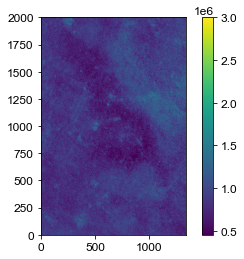

In [83]:
plt.imshow(T_weighted_plot, vmin = np.nanmin(T_weighted), vmax = 3e6, origin='lower')
plt.colorbar()
plt.contour(CHB)

In [144]:
np.nanmax(T_weighted)

8572931.997334301